In [6]:
import numpy as np
import cv2 as cv
from PIL import Image
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [7]:
EPISODES = 30000
SHOW_EVERY = 3000

epsilon = 0.6
EPS_DECAY = 0.9998
DISCOUNT = 0.95
LEARNING_RATE = 0.1

In [8]:
class Cube:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, self.size)
        self.y = np.random.randint(0, self.size)

    def __str__(self) -> str:
        return f"{self.x},{self.y}"

    def __sub__(self, other: "Cube"):
        return (self.x - other.x, self.y - other.y)

    def __eq__(self, other: object) -> bool:
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=1)
        elif choice == 2:
            self.move(x=1, y=-1)
        elif choice == 3:
            self.move(x=-1, y=-1)
        elif choice == 4:
            self.move(x=0, y=1)
        elif choice == 5:
            self.move(x=0, y=-1)
        elif choice == 6:
            self.move(x=1, y=0)
        elif choice == 7:
            self.move(x=-1, y=0)
        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        if self.x <= 0:
            self.x = 0
        elif self.x >= self.size:
            self.x = self.size - 1

        if self.y <= 0:
            self.y = 0
        elif self.y >= self.size:
            self.y = self.size - 1

In [9]:
p1 = Cube(10)
p2 = Cube(10)
print(p1)
print(p2)
print(p1 == p2)

3,8
4,4
False


In [10]:
class envCube:
    SIZE = 10
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)
    ACTION_SPACE_VALUES = 9
    RETURN_IMAGE = False

    FOOD_REWARD = 25
    ENEMY_PENALTY = -300
    MOVE_PENALTY = -1
    d = {
        1: (255, 0, 0),  # blue
        2: (0, 255, 0),  # green
        3: (0, 0, 255),  # red
    }

    PLAYER_N = 1
    FOOD_N = 2
    ENEMY_N = 3

    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        while self.food == self.player:
            self.food = Cube(self.SIZE)

        self.enemy = Cube(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Cube(self.SIZE)

        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food) + (self.player - self.enemy)

        self.episode_step = 0
        return observation

    def step(self, action):
        self.episode_step += 1
        self.player.action(action)
        self.food.move()
        self.enemy.move()

        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food) + (self.player - self.enemy)

        if self.player == self.food:
            reward = self.FOOD_REWARD
        if self.player == self.enemy:
            reward = self.ENEMY_PENALTY
        else:
            reward = self.MOVE_PENALTY

        done = False
        if self.player == self.food or self.player == self.enemy or self.episode_step >= 200:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((800, 800))
        cv.imshow("img", np.array(img))
        cv.waitKey(1)

    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]

        img = Image.fromarray(env, "RGB")
        return img

    def get_qtable(self, qtable_name=None):
        if qtable_name is None:
            q_table = {}
            for x1 in range(-self.SIZE + 1, self.SIZE):
                for y1 in range(-self.SIZE + 1, self.SIZE):
                    for x2 in range(-self.SIZE + 1, self.SIZE):
                        for y2 in range(-self.SIZE + 1, self.SIZE):
                            q_table[((x1, y1, x2, y2))] = [
                                np.random.uniform(-5, 0) for i in range(self.ACTION_SPACE_VALUES)
                            ]
        else:
            with open(qtable_name, "rb") as f:
                q_table = pickle.load(f)
        return q_table

In [11]:
env = envCube()
print(env.reset())
new_observation, reward, done = env.step(3)
print(new_observation, reward, done)
env.render()
q_table1 = env.get_qtable()
q_table1[new_observation]

(0, -4, 3, 4)
(-1, -5, 2, 3) -1 False


[-3.163325873830061,
 -4.611274342089867,
 -0.5732203758412435,
 -2.7543659722794347,
 -4.946557562812518,
 -3.2122304343176826,
 -1.6593622713183946,
 -0.7783207592173298,
 -0.7848730543552849]

In [12]:
env = envCube()
q_table = env.get_qtable()

episode_rewards = []
for episode in range(EPISODES):
    obs = env.reset()
    done = False

    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon:{epsilon}")
        print(f"mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, env.ACTION_SPACE_VALUES)

        new_obs, reward, done = env.step(action)

        # 更新Q表
        current_q = q_table[obs][action]
        max_future_q = np.max(q_table[new_obs])

        if reward == env.FOOD_REWARD:
            new_q = env.FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

        q_table[obs][action] = new_q
        obs = new_obs

        if show:
            env.render()

        # 累加奖励
        episode_reward += reward

    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

on #0, epsilon:0.6
mean reward:nan


c:\APP\python3_11_9\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\APP\python3_11_9\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


on #3000, epsilon:0.32926722239570905
mean reward:-203.26033333333334
on #6000, epsilon:0.18069483957364205
mean reward:-197.67766666666665
on #9000, epsilon:0.09916147987941909
mean reward:-190.34766666666667
on #12000, epsilon:0.054417708414240505
mean reward:-179.77033333333333
on #15000, epsilon:0.029863279497827713
mean reward:-176.105
on #18000, epsilon:0.016388331819794114
mean reward:-169.56266666666667
on #21000, epsilon:0.00899356749667138
mean reward:-170.59933333333333
on #24000, epsilon:0.00493547831509555
mean reward:-164.612
on #27000, epsilon:0.0027084853933429503
mean reward:-167.84133333333332


27001


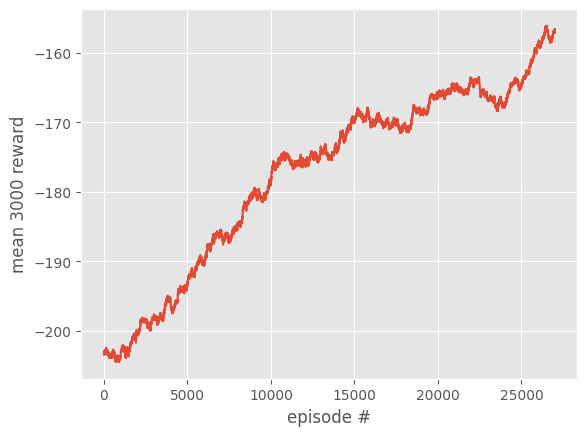

In [13]:
# conv = np.convolve([3, 8, 10, 9, 11, 23, 44, 55, 57, 48], np.ones((3,)) / 3, mode="valid")
# print(conv)
# print(np.ones((3,)) / 3)
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode="valid")
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel("episode #")
plt.ylabel("mean 3000 reward")
plt.show()

# 保存q table
with open(f"qtable_{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

In [17]:
with open('qtable_1726499931.pickle','rb') as f:
    q_table_s = pickle.load(f)

In [20]:
def test(q_table, episodes, show_enable=True):
    env = envCube()
    avg_reward = 0
    for episode in range(episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax(q_table[obs])
            obs, reward, done = env.step(action)
            if show_enable == True:
                env.render()

            episode_reward += reward
        print(f"episode:{episode}, episode_reward:{episode_reward}")
        avg_reward += episode_reward
    avg_reward /= episodes

    print(f'avg_reward:{avg_reward}')
    return avg_reward

In [21]:
test(q_table_s, 10)

episode:0, episode:-149
episode:1, episode:-200
episode:2, episode:-99
episode:3, episode:-357
episode:4, episode:-462
episode:5, episode:-14
episode:6, episode:-28
episode:7, episode:-200
episode:8, episode:-8
episode:9, episode:-200
avg_reward:-171.7


-171.7